# Federated Learning Simulation
Federated Learning (FL) allows machine learning algorithms to gain insights into a broad range of datasets located at different locations, enabling a privacy-preserving model development [1]. It was announced in 2016 by Google [2]. Clients contribute locally-trained models, the data never leaning their device! 

In this simulation, we will be performing Federated Learning with a dataset of human activity with CNN. 

## Imports
In the following lines we are making all the neccesary inputs. We will be working with Keras. 

In [1]:
import collections

import numpy as np
import pandas as pd 
import tensorflow as tf
import datetime
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling1D
from keras import backend as K

## Settings 
These are simple settings to personalize our simulation. The simulation is based on the description provided by [3] 

A. The device downloads the current model. Here we refer to this model as global_model, and first all the clients connected in that round download the current state of this model to work with. 

B. The changes, denoted in this project by the weights, are averaged with other's users updates. 

C. This average is used to update the current model. 

Next batch of users will work with the updated model, make their own updates, and so on. 

You can modify the following settings, being mindful that these changes will be impactful in the accuracy result, as well as in the use of computational resources. 

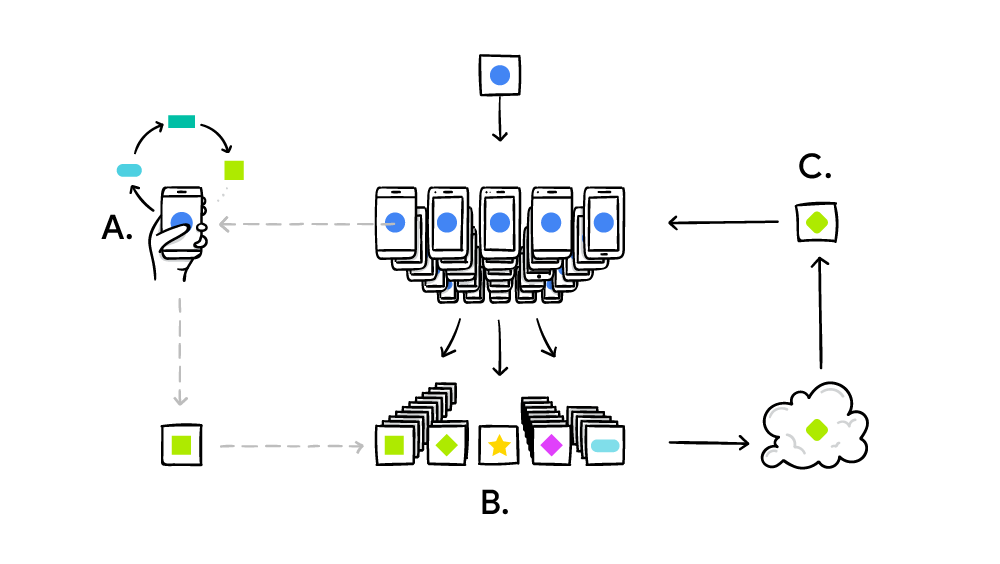
Your phone personalizes the model locally, based on your usage (A). Many users' updates are aggregated (B) to form a consensus change (C) to the shared model, after which the procedure is repeated. Source: https://ai.googleblog.com/2017/04/federated-learning-collaborative.html 

In [2]:
"""
BATCH_SIZE: When a client connects, how many data would they produce? (int) Data would be picked randomly from their dataset.

BATCH_SIZE_RANDOM: Simulate that the user gives different amount of data each time. By default, it will pick from an array from 100 to BATCH_SIZE. 

ROUNDS: How many times are we going to recolect the data? (int)

POPULAR_CLIENTS_CONNECTED: Maybe not all users connect at the same round. How many users usually connect? (list) 
In federated learning, training usually follows a strict schedule depending on the device status [3]. If this is not the case, we can just add 
the total number of clients as the only element in the list.
For each round, one of these numbers will be chosen. Please notice that the biggest number should be the len of clients.

NUM_EPOCHS: Number of epoch for training

CLIENT_ID_COLNAME: The column in our dataset that indicates to which user does the data belong

SHOW_EPOCHS: modifies the verbose. Change it to 1 if you want to see the training live!
"""
BATCH_SIZE = 200
BATCH_SIZE_RANDOM = True
ROUNDS = 25
POPULAR_CLIENTS_CONNECTED = [7, 9, 8, 14]
NUM_EPOCHS = 20
CLIENT_ID_COLNAME = 'subject'
SHOW_EPOCHS = 0

## Data Exploration
In this step we will load our data and do a little exploration. In this case is possible, but usually in a federated learning setting we wil not have any kind of access to the data. We can't always look at data while developing the models, even if we already have some data the policies might not allow us to use it. So, development could definetly get trickier [4] 

In [3]:
# loading datasets. Please add in the folder data both datasets! 
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
# checking our dataset
train.head()

,subject,acc1_x,acc1_y,acc1_z,gyro1_x,gyro1_y,gyro1_z,acc2_x,acc2_y,acc2_z,label
0,3,-0.049573,0.051482,0.061498,0.357428,0.876525,-1.077288,0.951736,-0.303094,-0.133766,5
1,3,-0.085298,0.048648,0.083263,0.337020,0.840771,-1.329607,0.918129,-0.301953,-0.111281,5
2,3,-0.046568,0.057793,0.114970,0.320000,0.909147,-0.788201,0.958863,-0.288855,-0.078756,5
3,3,0.001564,0.068723,0.144465,0.308596,0.773221,-0.313850,1.008886,-0.274002,-0.048346,5
4,3,-0.026644,0.088834,0.188589,0.308176,0.691534,-0.457948,0.982454,-0.250003,-0.003217,5


This dataset was provided is based on [5]. This dataset recopiles data from sensors from twenty volunteers doing several physical activities. For a visual representation of the experiment, refer to [6]. 

Our data for simulation looks very clean and won't need any extra data cleaning. Let's now check how our data looks. We will see the behaviour of data of one client. 

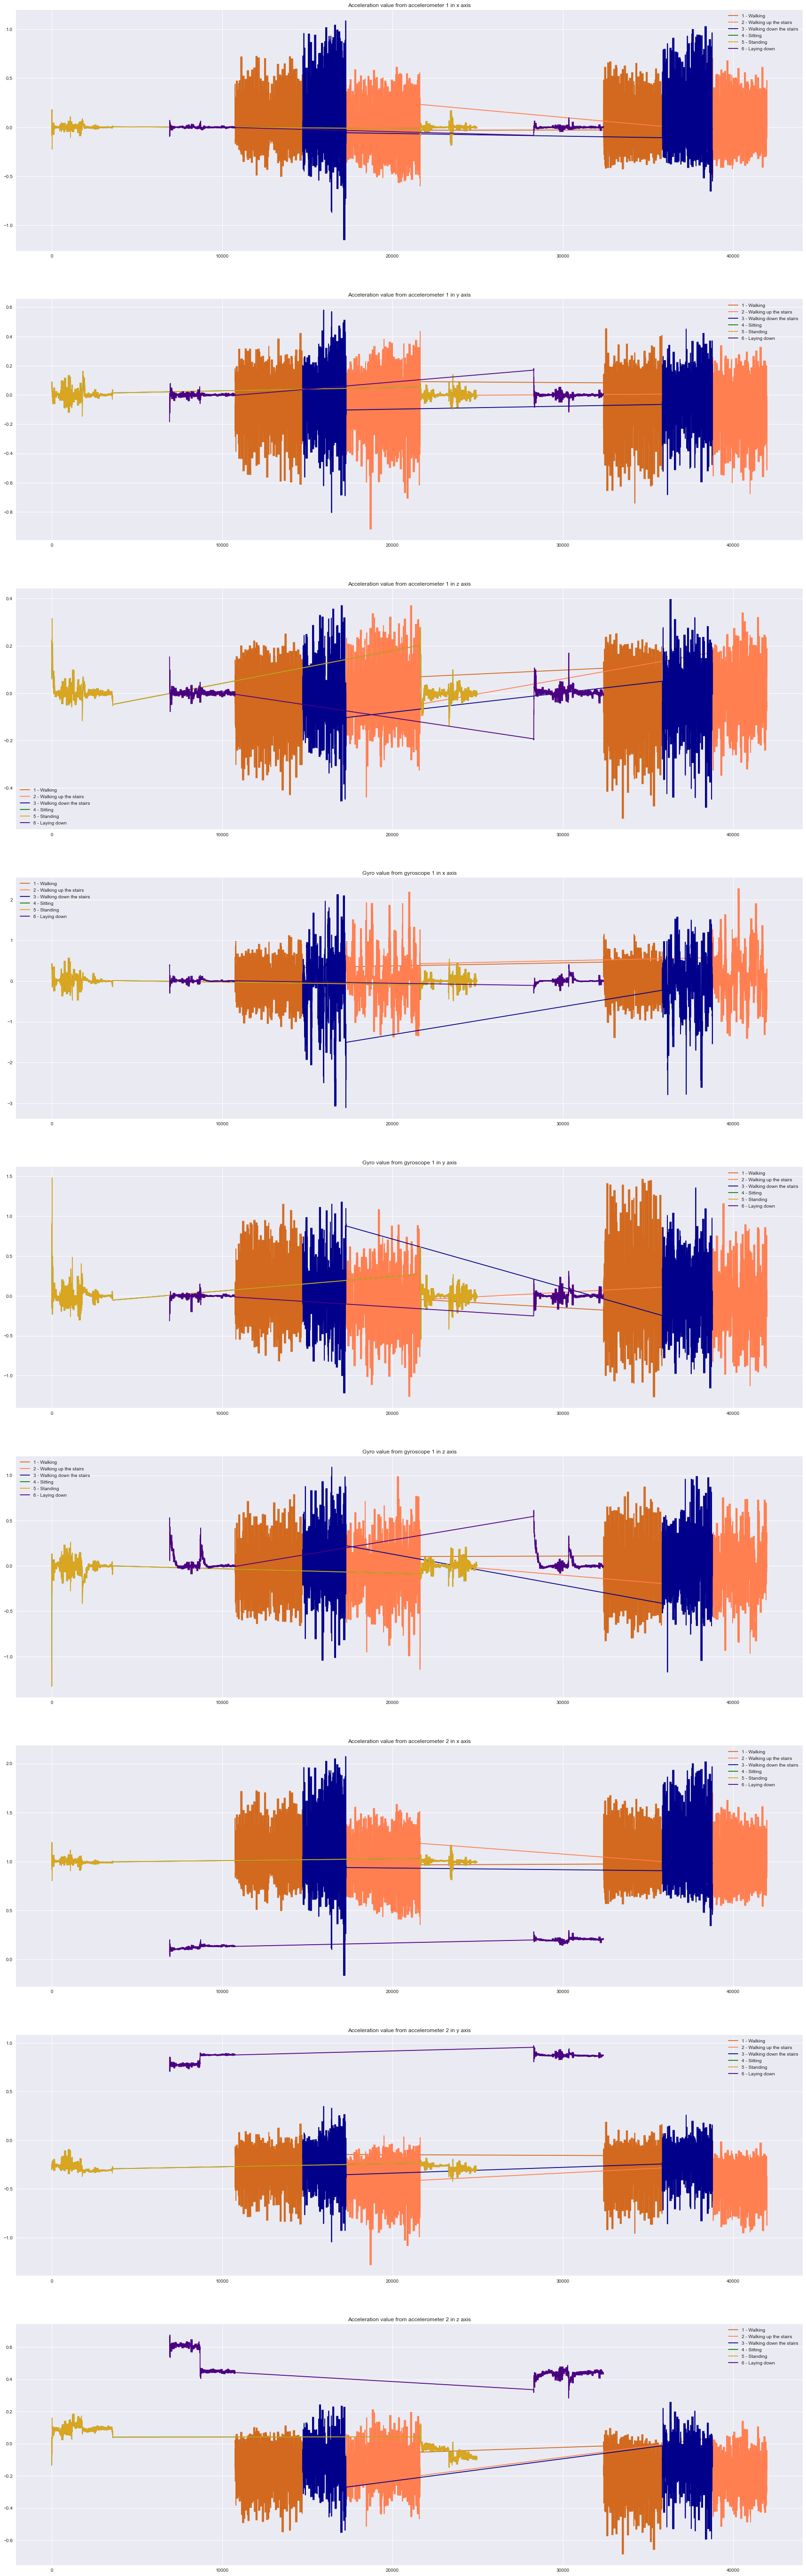

In [4]:
client_dfs = []
for subject, df_subject in train.groupby('subject'):
    client_dfs.append(df_subject)

sample_client = client_dfs[0]
mpl.style.use('seaborn')
fig, ax = plt.subplots(9 , 1, figsize=(30, 100), facecolor='w', edgecolor='k')
column_names = [
    'Acceleration value from accelerometer 1 in x axis',
    'Acceleration value from accelerometer 1 in y axis',
    'Acceleration value from accelerometer 1 in z axis',
    'Gyro value from gyroscope 1 in x axis',
    'Gyro value from gyroscope 1 in y axis',
    'Gyro value from gyroscope 1 in z axis',
    'Acceleration value from accelerometer 2 in x axis',
    'Acceleration value from accelerometer 2 in y axis',
    'Acceleration value from accelerometer 2 in z axis'
]

labels = [
    '1 - Walking',
    '2 - Walking up the stairs',
    '3 - Walking down the stairs', 
    '4 - Sitting',
    '5 - Standing', 
    '6 - Laying down'
]

color_labels = {
    '1': 'chocolate',
    '2': 'coral',
    '3': 'darkblue',
    '4': 'green', 
    '5': 'goldenrod',
    '6': 'indigo'
}
for index in range(1, 10):
    sample_client[sample_client['label']==1].plot(y=index, color=color_labels['1'], label=labels[0], ax=ax[index-1], legend=True, title=column_names[index-1])
    sample_client[sample_client['label']==2].plot(y=index, color=color_labels['2'], label=labels[1], ax=ax[index-1], legend=True, title=column_names[index-1])
    sample_client[sample_client['label']==3].plot(y=index, color=color_labels['3'], label=labels[2], ax=ax[index-1], legend=True, title=column_names[index-1])
    sample_client[sample_client['label']==5].plot(y=index, color=color_labels['4'], label=labels[3], ax=ax[index-1], legend=True, title=column_names[index-1])
    sample_client[sample_client['label']==5].plot(y=index, color=color_labels['5'], label=labels[4], ax=ax[index-1], legend=True, title=column_names[index-1])
    sample_client[sample_client['label']==6].plot(y=index, color=color_labels['6'], label=labels[5], ax=ax[index-1], legend=True, title=column_names[index-1])

### Exploring heterogeneity
Federated data is typically non-i.i.d., users typically have different distributions of data depending on usage patterns [4]. Let's check if this specfic dataset is non-i.i.d by looking at our training data. It's important to remember that this analysis is only possible for this simulation environment, because in real production we would not be able to inspect data. A client could have updated our model with only a few training examples, and our model would update accordingly nonetheless. 

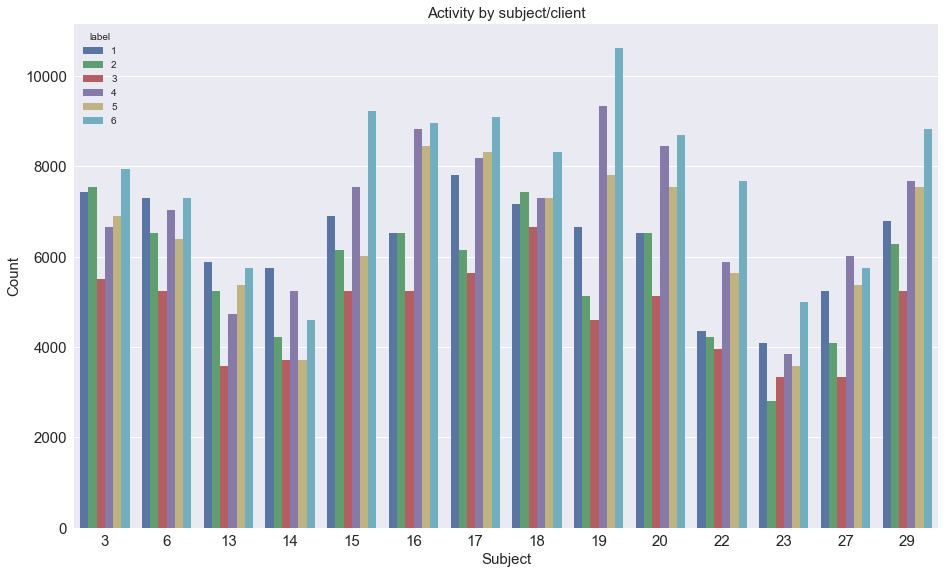

In [5]:
# label counts for all clients 

fig = plt.figure(figsize=(12, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title("Activity by subject/client", fontsize = 15)
plt.tick_params(labelsize = 15)
sns.countplot(x = 'subject', hue = 'label', data = train)
plt.xlabel("Subject", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.show()

We can see this is non-IID dataset -it replicates real-world settings where all subjects do not provide the same amount of data, thought they all did the six activities. 

Other than the amount, we can also check how our data behaves for each user with their mean and then in general. 

In [6]:
# checking the mean for each subject
means = []
for client_df in client_dfs: 
    means.append(client_df.mean(axis = 0))

mean_df = pd.DataFrame(means)
mean_df = mean_df.astype({"subject": int})
mean_df = mean_df.drop(['label'], axis=1)
mean_df.set_index('subject', inplace=True)
mean_df

,acc1_x,acc1_y,acc1_z,gyro1_x,gyro1_y,gyro1_z,acc2_x,acc2_y,acc2_z
subject,,,,,,,,,
3,-0.001007,-0.000477,0.000678,0.006000,-0.000808,0.000090,0.828859,0.001205,0.046003
6,-0.000862,-0.000552,-0.002886,-0.020194,0.001947,0.005169,0.814170,0.044521,0.040383
13,-0.001050,-0.000630,-0.000562,-0.034095,0.006756,0.007094,0.835545,-0.018523,0.030799
14,-0.001382,0.000380,0.001156,0.028421,-0.009526,-0.009737,0.804510,-0.078347,-0.137896
15,0.000092,0.000352,-0.001377,-0.001564,-0.000554,0.001587,0.818828,0.126866,0.028574
16,0.000042,0.000745,0.000371,0.015924,0.001201,-0.006107,0.823126,-0.040623,0.046844
17,-0.000824,-0.000249,-0.000436,0.012170,-0.003778,-0.003481,0.823075,0.014324,-0.016001
18,-0.000265,-0.000118,0.000051,-0.011353,0.003201,0.001455,0.833546,0.012921,0.090730
19,-0.001695,-0.000512,-0.003487,-0.009601,0.002630,0.000460,0.656321,0.127806,0.226485


In [7]:
mean_df.describe()

,acc1_x,acc1_y,acc1_z,gyro1_x,gyro1_y,gyro1_z,acc2_x,acc2_y,acc2_z
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,-0.000784,-0.000122,-0.000461,0.000191,-0.001011,-0.000156,0.794686,0.034709,0.079689
std,0.000731,0.000505,0.001352,0.018180,0.005018,0.004545,0.047843,0.064678,0.100597
min,-0.001937,-0.000679,-0.003487,-0.034095,-0.009810,-0.009737,0.656321,-0.078347,-0.137896
25%,-0.001299,-0.000542,-0.000955,-0.010915,-0.003472,-0.002861,0.780306,-0.003107,0.033195
50%,-0.000935,-0.000200,0.000015,0.000401,-0.000681,0.000275,0.812859,0.029304,0.062618
75%,-0.000251,0.000302,0.000345,0.014985,0.002459,0.001554,0.823113,0.059223,0.126375
max,0.000579,0.000745,0.001156,0.028421,0.006756,0.007094,0.835545,0.140032,0.238991


## Functions 
Here we will inspect a little the functions used. 

In [8]:
def get_random_batch_size():
    """
        Will give us a random number for the amount of data given by user during a round. 
        This number will be any number between 100 and BATCH_SIZE. 
        Keep in mind the number is very small we can have issues with our model. 
        
        :returns a number between 100 and BATCH_SIZE 
    """
    random_choices = [x+1 for x in range(BATCH_SIZE)]
    choice = int(np.random.choice(random_choices, 1))
    if(choice < 100): choice = 100
    return choice

In [9]:
def get_X_y(client_id):
    
    """
    
    This function will give us a sample of X and y from the train dataset. This function simulates the user's device
    giving us data. It also modifies our X and y for them to fit correctly into our model.
    
    If BATCH_SIZE_RANDOM is set to true, it will pick a random amount of data for each client in each round. 
    
    Keep in mind that when selecting a sample, the same data can be used in another sample. While this is not the best
    simulation behaviour, until future enhacements it will be kept this way. 
    
    Keyword arguments: 
    
    client_id -- the number of subject we want data from.
        
    """

    client_data = train[train[CLIENT_ID_COLNAME] == client_id]
    
    if(BATCH_SIZE_RANDOM):
        batch_size = get_random_batch_size()
    else:
        batch_size = BATCH_SIZE
    
    #print("CLIENT SELECTED: ", client_id, "AMOUNT OF DATA: ", batch_size)
    
    client_data = client_data.sample(n = batch_size, replace = False)
    y = client_data['label']
    X = client_data.drop(['label', 'subject'], axis=1)
    X = np.expand_dims(X, axis=2)
    y = to_categorical(y)
    return X, y

The model used is based on [8], but with notable differences. M. Zeng et al. achieved excelent results by separating first the data of the axis X, Y, Z and applying convolution and max pooling before concatenating the results in a hidden layer. I first tried this approach but got very poor results in comparison. My hypothesis is that it happens because we are sending samples just within the same subject, but further analysis is required. 

In [10]:
def get_keras_model():
    """
    Our keras model that serves as base. 
    """
    return tf.keras.Sequential([    
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(9, 1)),   
        MaxPooling1D(pool_size=3),
        Flatten(),
        Dense(1024, activation='relu'),
        Dense(30, activation='relu'),
        Dense(7, activation='softmax')])

In [26]:
mod = get_keras_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 64)             256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1024)              132096    
                                                                 
 dense_1 (Dense)             (None, 30)                30750     
                                                                 
 dense_2 (Dense)             (None, 7)                 217       
                                                        

In [11]:
"""
Source of the code from the metrics [9]
"""
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
def compile_model(model):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',              
        metrics=['accuracy', f1_m]
    )
    return model

In [13]:
def fit_model(model, X, y):
    history = model.fit(
        X, 
        y,
        epochs = NUM_EPOCHS,
        validation_split=0.2, 
        verbose = SHOW_EPOCHS
    )
    return history, model

In [14]:
def give_sample_clients():
    """
    This function is to obtain how many clients certain round will work it. 
    It represents the amount of clients that will be agreggated together by federated learning. 
    
    """
    num_clients = int(np.random.choice(POPULAR_CLIENTS_CONNECTED, 1))
    return np.random.choice(train_client_ids, num_clients).tolist()

In [15]:
def update_global_model(weights):
    """
    Here is when the changes given by the clients will update our global model. 
    """
    global_model.set_weights(weights)

In [16]:
def get_current_global_model():
    """
    This function is to give each client a copy of our global model to start working with when they participate in a round. 
    """
    copy = tf.keras.models.clone_model(global_model)
    copy.set_weights(global_model.get_weights())
    return copy

In [17]:
def get_avg_weights(weights, client_batch_models):
    """
    This function will get the average of weights for n clients in a certain round. 
    """
    avg_weights = []
    num_models = len(client_batch_models)
    num_layers = len(client_batch_models[0].get_weights())
    for layer in range(num_layers):
        layer_weights = np.array([model.get_weights()[layer] for model in client_batch_models])
        avg_layer_weights = np.average(layer_weights, axis=0, weights=weights)
        avg_weights.append(avg_layer_weights)
    return avg_weights;
    

## General variables
Variables that will be used for our function 

In [18]:
train_client_ids = train[CLIENT_ID_COLNAME].unique().tolist()
test_client_ids = test[CLIENT_ID_COLNAME].unique().tolist()

In [19]:
global_model = get_keras_model()
global_model = compile_model(global_model)

## Federated Learning
We are going to finally simulate our federated learning! 

In [20]:
# aggregate per round: our global model updates n times with n amount of clients. 

all_history = [] # we will be saving our story so we can use it later to graph! 

for round in range(ROUNDS):
    sample_clients = give_sample_clients() # the ids of the clients we will have in this round
    sample_history = [] # history of the clients in this current round
    sample_clients_models = [] # models of the clients in this current round
    
    for client_id in sample_clients:
        # each round of clients will start with the same global model 
        model = get_current_global_model()
        X, y = get_X_y(client_id) # they wil get their little batch of data for this round
        model = compile_model(model)
        history, model = fit_model(model, X, y)
        sample_clients_models.append(model)
        sample_history.append(history)
        all_history.append(history)
    weights = [] # we will save the max of weights of each client of the current round
    for history_client in sample_history: 
        weights.append(max(history_client.history['accuracy']))
    # the weights of the round are sent to the 'cloud' to update global model
    avg_weights = get_avg_weights(weights, sample_clients_models) 
    update_global_model(avg_weights)
    print("--> Round: ", round+1, ": global model has been updated")

--> Round:  0 : global model has been updated
--> Round:  1 : global model has been updated
--> Round:  2 : global model has been updated
--> Round:  3 : global model has been updated
--> Round:  4 : global model has been updated
--> Round:  5 : global model has been updated
--> Round:  6 : global model has been updated
--> Round:  7 : global model has been updated
--> Round:  8 : global model has been updated
--> Round:  9 : global model has been updated
--> Round:  10 : global model has been updated
--> Round:  11 : global model has been updated
--> Round:  12 : global model has been updated
--> Round:  13 : global model has been updated
--> Round:  14 : global model has been updated
--> Round:  15 : global model has been updated
--> Round:  16 : global model has been updated
--> Round:  17 : global model has been updated
--> Round:  18 : global model has been updated
--> Round:  19 : global model has been updated
--> Round:  20 : global model has been updated
--> Round:  21 : global

## Results 

In [24]:
y = test['label']
X = test.drop(['label', 'subject'], axis=1)
X = np.expand_dims(X, axis=2)
y = to_categorical(y)

evaluation = global_model.evaluate(X, y)

8232/8232 [==============================] - 12s 2ms/step - loss: 0.9913 - accuracy: 0.7133 - f1_m: 0.7073


Under the following settings: 

```BATCH_SIZE = 200
BATCH_SIZE_RANDOM = True
ROUNDS = 25
POPULAR_CLIENTS_CONNECTED = [7, 9, 8, 14]
NUM_EPOCHS = 20
CLIENT_ID_COLNAME = 'subject'
SHOW_EPOCHS = 0
```
We could get an accuracy of 71.33% and a F1 score of 70.73% 

## Conclusions and future work

Federated Learning is an interesting topic, but what makes it an urgent subject to be studied is its focus on user's data privacy. Industry 4.0 realized the potential of data and I'm glad to learn a technique from the Industry 5.0 point of view - industry must contribute to society. 

I'm content with the accuracy and F1 Score but they can certainly be improved. Depending on the settings, the accuaracy could go up to ~85%, but it was important to take into consideration that we don't have unlimited amounts for our simulation. This current version of the project takes random data from the user's dataset and a big batch size could give us overfitting and not a good representation of Federated Learning. 

There is still much work to do! For example, I did grid search but from the non-FL point of view, so we still have to tune hyperparameters for this model. This simulation, by taking the same size of data from each user per round independently of how much data the user actually has, especially in comparasion with other users, does not take into consideration the problem of having a non-IID dataset.

Apart from this simulation, there are frameworks for Federated Learning that we could apply for this problem. While I especially researched [Tensor Flow Federated](https://www.tensorflow.org/federated?hl=es-419), for this version there was not enough time to apply it as I should have liked, but it's certainly an area of opportunity along with [Flower](https://flower.dev/). 

As I learn more from Federated Learning, I think it will be interesting to work on its challenges - like the devices' reliability and the unbalanced data distribution. Federated Learning will surely be even more of an important topic in the upcoming years.

## Bibliography

[1] Li, Qinbin, Zeyi Wen, Zhaomin Wu, Sixu Hu, Naibo Wang, Yuan Li, Xu Liu, and Bingsheng He. “A Survey on Federated Learning Systems: Vision, Hype and Reality for Data Privacy and Protection.” arXiv.org, 2019. https://arxiv.org/abs/1907.09693.

[2] Brendan, McMahan H, Eider Moore, Daniel Ramage, Seth Hampson, and Arcas, Blaise Agüera y. “Communication-Efficient Learning of Deep Networks from Decentralized Data.” arXiv.org, 2016. https://arxiv.org/abs/1602.05629.

[3] “Federated Learning: Collaborative Machine Learning without Centralized Training Data.” Google AI Blog, April 6, 2017. https://ai.googleblog.com/2017/04/federated-learning-collaborative.html.

[4] Ostrowski, Krzysztof. “TensorFlow Federated (TFF): Machine Learning on Decentralized Data (TF Dev Summit ‘19).” Www.youtube.com, 7 Mar. 2019, www.youtube.com/watch?v=1YbPmkChcbo. Accessed 22 Oct. 2021.

[5] “A Public Domain Dataset for Real-Life Human Activity Recognition Using Smartphone Sensors.” Lbd.udc.es, 2020. https://lbd.udc.es/research/real-life-HAR-dataset/.

[6] Reyes Ortiz, José Luis. “Activity Recognition Experiment Using Smartphone Sensors.” Www.youtube.com, 19 Oct. 2012, www.youtube.com/watch?v=XOEN9W05_4A&t=27s. Accessed 24 Oct. 2021.

[7] aalaei. “FedSim/A_Tutorial_on_FL_API.ipynb at Main · Aalaei/FedSim.” GitHub, March 2, 2021. https://github.com/aalaei/FedSim/blob/main/A_Tutorial_on_FL_API.ipynb.

[8] M. Zeng et al., "Convolutional Neural Networks for human activity recognition using mobile sensors," 6th International Conference on Mobile Computing, Applications and Services, 2014, pp. 197-205, doi: 10.4108/icst.mobicase.2014.257786.

[9] How to get accuracy, F1, precision and recall, for a keras model. “How to Get Accuracy, F1, Precision and Recall, for a Keras Model?” Data Science Stack Exchange, February 6, 2019. https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model.

[10] K. Sozinov, V. Vlassov and S. Girdzijauskas, "Human Activity Recognition Using Federated Learning," 2018 IEEE Intl Conf on Parallel & Distributed Processing with Applications, Ubiquitous Computing & Communications, Big Data & Cloud Computing, Social Computing & Networking, Sustainable Computing & Communications (ISPA/IUCC/BDCloud/SocialCom/SustainCom), 2018, pp. 1103-1111, doi: 10.1109/BDCloud.2018.00164. 

